In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


In [ ]:
data = pd.read_csv('SX7E.csv')[['Date', 'Price']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=False,inplace=True)
log_returns = (np.log(data[['Price']] / data[['Price']].shift(1)).dropna())*1000


VSTOXX = pd.read_csv('VSTOXX.csv')
VSTOXX['Date'] = pd.to_datetime(VSTOXX['Date'])
VSTOXX.set_index('Date', inplace=True)

VIX = pd.read_csv('VIX_History.csv')[['DATE', 'CLOSE']]
VIX.columns = ['Date', 'VIX']
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX.set_index('Date', inplace=True)


weekly_log_ret = log_returns['Price'].groupby(pd.Grouper(freq="W-FRI")).sum()
weekly_VSTOXX = VSTOXX['VSTOXX'].groupby(pd.Grouper(freq="W-FRI")).mean()
weekly_VIX = VIX['VIX'].groupby(pd.Grouper(freq="W-FRI")).mean()

combined = pd.merge(weekly_log_ret, weekly_VSTOXX, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_VIX, how='left', on='Date')
combined.dropna(inplace=True)

#daily
# combined = pd.merge(log_returns, VSTOXX, how='left', on='Date')
# combined.dropna(inplace=True)
# combined = pd.merge(combined, VIX, how='left', on='Date')
# combined.dropna(inplace=True)


combined.columns = ['Log Return', 'VSTOXX', 'VIX']

In [ ]:
combined

,Log Return,VSTOXX,VIX
Date,,,
2009-01-02,-44.557730,43.032133,41.1800
2009-01-09,23.454954,41.085640,41.2820
2009-01-16,189.253048,49.743320,47.0720
2009-01-23,21.619400,51.461060,49.4075
2009-01-30,-35.697978,44.693620,43.0140
...,...,...,...
2025-07-04,-15.795777,17.872800,16.8120
2025-07-11,-3.666320,17.119120,16.5440
2025-07-18,1.855922,17.927780,16.9340


In [ ]:
log_returns['Price'].mean()

np.float64(-0.1073416020596213)

In [ ]:
eps = 1e-5 # to avoid numerical issues lates, a few rows of all sample 13 out of >3000 for daily data and 2 value out of >800 for weekly
combined.loc[abs(combined['Log Return']) < eps, 'Log Return'] = 1e-2

In [ ]:
combined.loc[abs(combined['Log Return']) < 1e-2, 'Log Return']

,Log Return
Date,


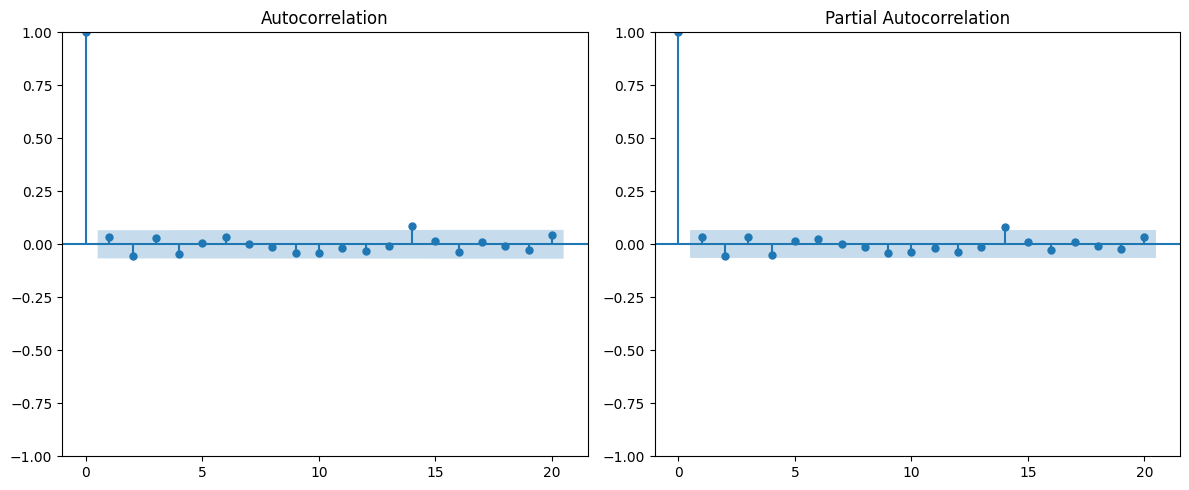

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(combined['Log Return'], lags=20, ax=plt.gca())

plt.subplot(1, 2, 2)
plot_pacf(combined['Log Return'], lags=20, ax=plt.gca(), method="ywm")  # PACF plot (Yule-Walker method)

plt.tight_layout()
plt.show()


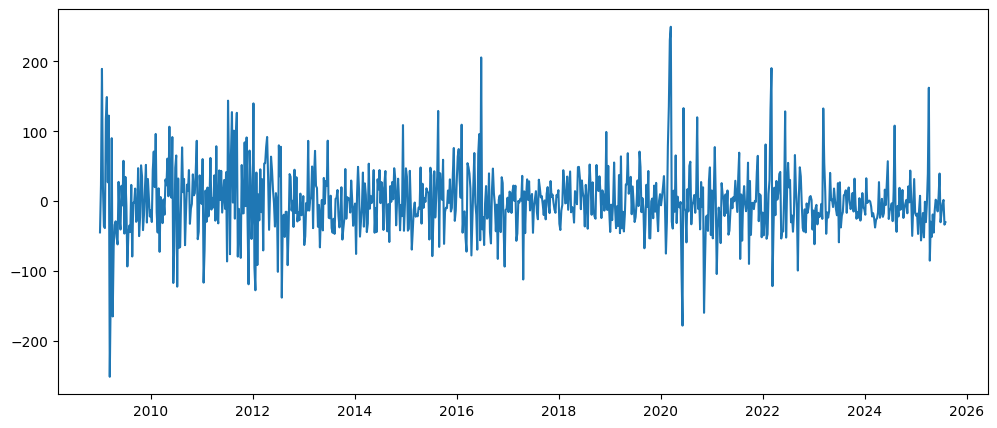

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(combined.index, combined['Log Return'])
plt.show()


In [ ]:
ln_E_sq = np.log(combined['Log Return'] ** 2)


In [ ]:
ln_E_sq = ln_E_sq.to_frame()
ln_E_sq[ln_E_sq['Log Return'] == np.min(ln_E_sq['Log Return'])]

,Log Return
Date,
2019-10-25,-9.21034
2021-06-11,-9.21034


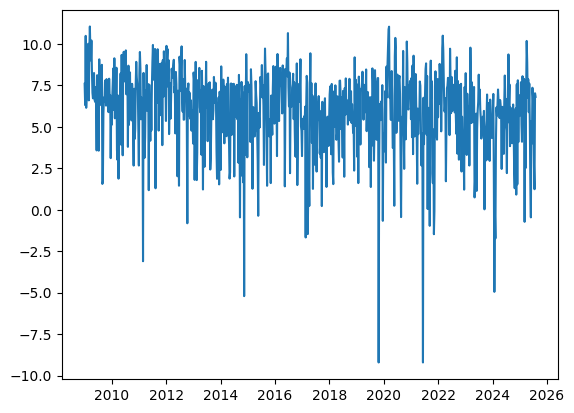

In [ ]:
plt.plot(ln_E_sq)

In [ ]:
len(combined[['VSTOXX']])

866

In [ ]:
def scale(x):
    return x - np.mean(x)
X_lagged = combined[['VSTOXX']].shift(1).dropna()
model = sm.tsa.SARIMAX(trend='c', endog=ln_E_sq[1:], order=(1,0,1), exog=X_lagged, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
# so far better off with only VSTOXX
print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  865
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1957.654
Date:                Mon, 29 Sep 2025   AIC                           3925.307
Time:                        11:41:22   BIC                           3949.109
Sample:                    01-09-2009   HQIC                          3934.418
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8854      1.226      2.353      0.019       0.482       5.289
VSTOXX         0.0800      0.012      6.585      0.000       0.056       0.104
ar.L1          0.3108      0.296      1.049      0.2

In [ ]:

residuals = res.resid
esimate_E_nu_sq = - np.log((1 / len(residuals)) * np.sum(np.exp(residuals)))
beta = - res.params[3]
alpha = res.params[2] - beta
omega = res.params[0] - (1 - beta) * esimate_E_nu_sq
[omega,alpha,beta]

/tmp/ipython-input-1434685678.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = - res.params[3]
/tmp/ipython-input-1434685678.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = res.params[2] - beta
/tmp/ipython-input-1434685678.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omega = res.params[0] - (1 - beta) * esimate_E_nu_sq


[np.float64(4.055177952212935),
 np.float64(0.09038900122359209),
 np.float64(0.2203998383311068)]

,0
VSTOXX,22.117313


In [ ]:
T = int(round(len(combined)/2,0))
H = len(combined)

In [ ]:
# rolling window estimation:
cond_log_var = np.zeros(len(combined))
LR_log_var = (omega + alpha*esimate_E_nu_sq + res.params[1] * np.mean(X_lagged))/(1- (alpha + beta))
cond_log_var[0] = LR_log_var
X_lagged = combined[['VSTOXX']].shift(1).dropna()

for t in range(int(H-T)):
  model = sm.tsa.SARIMAX(trend='c', endog=ln_E_sq[t+1:int(T+t)], order=(1,0,1), exog=X_lagged[t:int(T+t-1)], enforce_stationarity=False, enforce_invertibility=False)
  res = model.fit(disp=False)
  residuals = res.resid
  esimate_E_nu_sq = - np.log((1 / len(residuals)) * np.sum(np.exp(residuals)))
  beta = - res.params[3]
  alpha = res.params[2] - beta
  omega = res.params[0] - (1 - beta) * esimate_E_nu_sq
  for i in range(t, T + t):
    cond_log_var[i+1] = omega + alpha * np.log(combined['Log Return'][i] ** 2) + beta * cond_log_var[i] + res.params[1] * combined['VSTOXX'][i]


Выходные данные были обрезаны до нескольких последних строк (5000).
/tmp/ipython-input-552938786.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = - res.params[3]
/tmp/ipython-input-552938786.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = res.params[2] - beta
/tmp/ipython-input-552938786.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omega = res.params[0] - (1 - beta) * esimate_E_nu_sq
/tmp/ipython-inpu

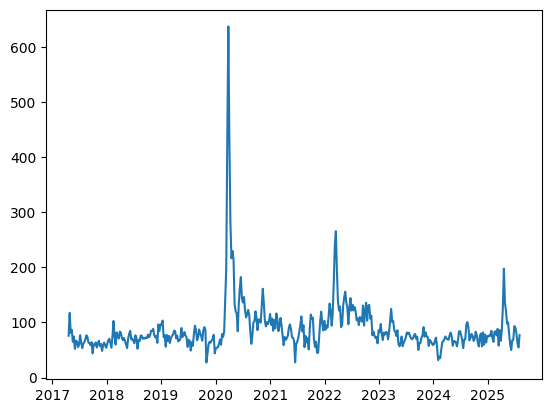

In [ ]:
vol_Log_GARCHX = np.sqrt(np.exp(cond_log_var))
plt.plot(combined[T:H].index,vol_Log_GARCHX[T:H])
plt.show()

In [ ]:
!pip install arch
from arch.univariate import arch_model

In [ ]:
# GARCH(1,1)
vol_GARCH = np.zeros(len(combined))
for t in range(int(H-T)):
  model = arch_model(combined['Log Return'][t:T+t], mean='Constant',
                  vol='GARCH', p=1, q=1, dist='StudentsT')
  res_garch = model.fit(disp=False)
  if t == 0:
    vol_GARCH[t:T+t] = res_garch.conditional_volatility
    vol_GARCH[T+t] = np.sqrt(res_garch.forecast(horizon=1).variance.values[-1, 0])
  else:
    vol_GARCH[T+t] = np.sqrt(res_garch.forecast(horizon=1).variance.values[-1, 0])


In [ ]:
combined['Log Return'][:T]

,Log Return
Date,
2009-01-02,-44.557730
2009-01-09,23.454954
2009-01-16,189.253048
2009-01-23,21.619400
2009-01-30,-35.697978
...,...
2017-03-17,0.480115
2017-03-24,-1.839191
2017-03-31,3.441242


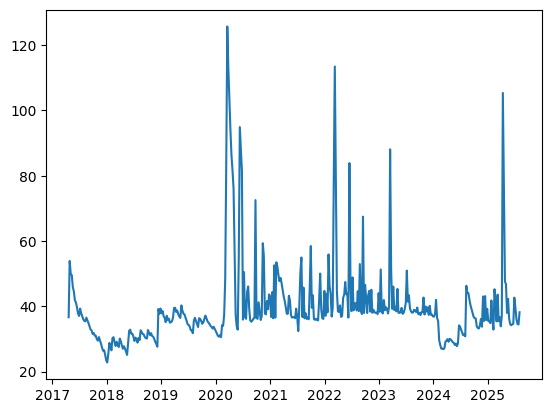

In [ ]:
plt.plot(combined.index[T:H], vol_GARCH[T:H])

In [ ]:
# TGARCH(1,1)
vol_TGARCH = np.zeros(len(combined))
for t in range(int(H-T)):
  model = arch_model(combined['Log Return'][t:T+t], mean='Constant',
                  vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
  res_tgarch = model.fit(disp=False)
  if t == 0:
    vol_TGARCH[t:T+t] = res_tgarch.conditional_volatility
    vol_TGARCH[T+t] = np.sqrt(res_tgarch.forecast(horizon=1).variance.values[-1, 0])
  else:
    vol_TGARCH[T+t] = np.sqrt(res_tgarch.forecast(horizon=1).variance.values[-1, 0])



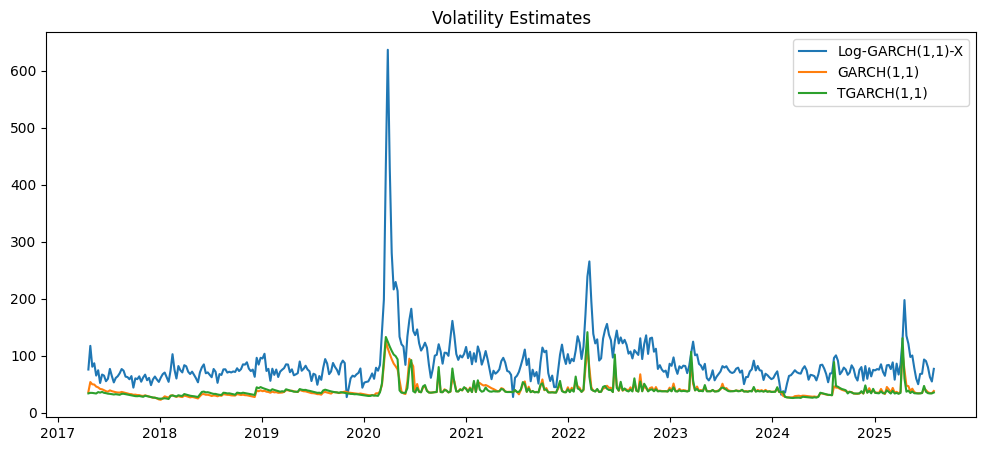

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(combined.index[T:H], vol_Log_GARCHX[T:H], label='Log-GARCH(1,1)-X')
plt.plot(combined.index[T:H], vol_GARCH[T:H], label='GARCH(1,1)')
plt.plot(combined.index[T:H], vol_TGARCH[T:H], label='TGARCH(1,1)')
plt.legend(['Log-GARCH(1,1)-X', 'GARCH(1,1)', 'TGARCH(1,1)'])
plt.title('Volatility Estimates')
plt.show()

In [ ]:
std_loss_LogGARCHX = np.zeros(H)
std_loss_GARCH = np.zeros(H)
std_loss_TGARCH = np.zeros(H)
std_loss_LogGARCHX[0:T] = - combined['Log Return'][0:T] / vol_Log_GARCHX[0:T]
std_loss_GARCH[0:T] = - combined['Log Return'][0:T] / vol_GARCH[0:T]
std_loss_TGARCH[0:T] = - combined['Log Return'][0:T] / vol_TGARCH[0:T]

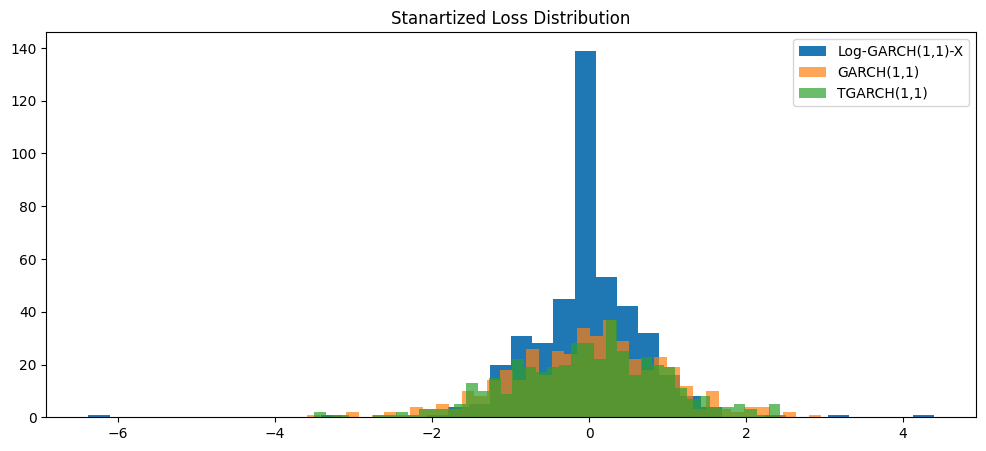

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(std_loss_LogGARCHX[0:T], bins=40)
plt.hist(std_loss_GARCH[0:T], bins=40, alpha=0.7)
plt.hist(std_loss_TGARCH[0:T], bins=40, alpha=0.7)
plt.legend(['Log-GARCH(1,1)-X', 'GARCH(1,1)', 'TGARCH(1,1)'])
plt.title('Stanartized Loss Distribution')
plt.show()

In [ ]:
VaR_LogGARCHX = np.zeros(H-T)
VaR_GARCH = np.zeros(H-T)
VaR_TGARCH = np.zeros(H-T)
VaR_naive = np.zeros(H-T)
ES_LogGARCHX = np.zeros(H-T)
ES_GARCH = np.zeros(H-T)
ES_TGARCH = np.zeros(H-T)
ES_naive = np.zeros(H-T)
for t in range(T,H):
  std_loss_LogGARCHX[t] = - combined['Log Return'][t] / vol_Log_GARCHX[t]
  std_loss_GARCH[t] = - combined['Log Return'][t] / vol_GARCH[t]
  std_loss_TGARCH[t] = - combined['Log Return'][t] / vol_TGARCH[t]
  VaR_LogGARCHX[t-T] = np.quantile(std_loss_LogGARCHX[t-T:t], 0.95) * vol_Log_GARCHX[t]
  VaR_GARCH[t-T] = np.quantile(std_loss_GARCH[t-T:t], 0.95) * vol_GARCH[t]
  VaR_TGARCH[t-T] = np.quantile(std_loss_TGARCH[t-T:t], 0.95) * vol_TGARCH[t]
  VaR_naive[t-T] = np.quantile(-combined['Log Return'][t-T:t], 0.95)
  ES_LogGARCHX[t-T] = np.mean(std_loss_LogGARCHX[t-T:t][std_loss_LogGARCHX[t-T:t] * vol_Log_GARCHX[t] > VaR_LogGARCHX[t-T]]) * vol_Log_GARCHX[t] / 0.05
  ES_GARCH[t-T] = np.mean(std_loss_GARCH[t-T:t][std_loss_GARCH[t-T:t] * vol_GARCH[t] > VaR_GARCH[t-T]]) * vol_GARCH[t] / 0.05
  ES_TGARCH[t-T] = np.mean(std_loss_TGARCH[t-T:t][std_loss_TGARCH[t-T:t] * vol_TGARCH[t] > VaR_TGARCH[t-T]]) * vol_TGARCH[t] / 0.05
  ES_naive[t-T] = np.mean(-combined['Log Return'][t-T:t][-combined['Log Return'][t-T:t] > VaR_naive[t-T]]) / 0.05

/tmp/ipython-input-2990277447.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_loss_LogGARCHX[t] = - combined['Log Return'][t] / vol_Log_GARCHX[t]
/tmp/ipython-input-2990277447.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_loss_GARCH[t] = - combined['Log Return'][t] / vol_GARCH[t]
/tmp/ipython-input-2990277447.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_loss_TGARCH[t] = - combined['Log Return'][t] / v

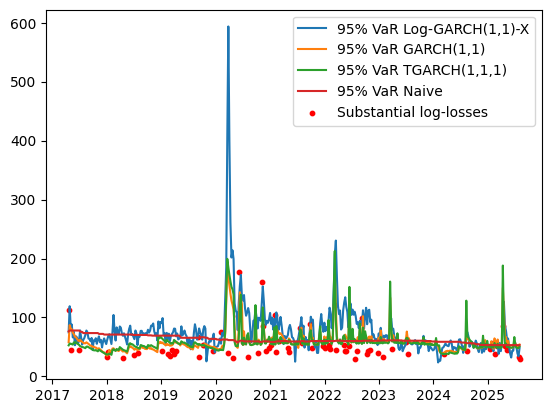

In [ ]:
# VaR_LogGARCHX = np.quantile(std_loss_LogGARCHX, 0.95) * vol
# VaR_GARCH = np.quantile(std_loss_GARCH, 0.95) * res_garch.conditional_volatility
# VaR_naive = np.full(len(vol),np.quantile(-combined['Log Return'], 0.95))
plt.plot(combined.index[T:H], VaR_LogGARCHX)
plt.plot(combined.index[T:H], VaR_GARCH)
plt.plot(combined.index[T:H], VaR_TGARCH)
plt.plot(combined.index[T:H], VaR_naive)
plt.scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], color='r',  s=10)
plt.legend(['95% VaR Log-GARCH(1,1)-X', '95% VaR GARCH(1,1)', '95% VaR TGARCH(1,1,1)','95% VaR Naive', 'Substantial log-losses'])
plt.show()

In [ ]:
combined[T:H]['Log Return']

,Log Return
Date,
2017-04-21,-111.921833
2017-04-28,14.087906
2017-05-05,-45.583112
2017-05-12,7.526995
2017-05-19,31.287138
...,...
2025-07-04,-15.795777
2025-07-11,-3.666320
2025-07-18,1.855922


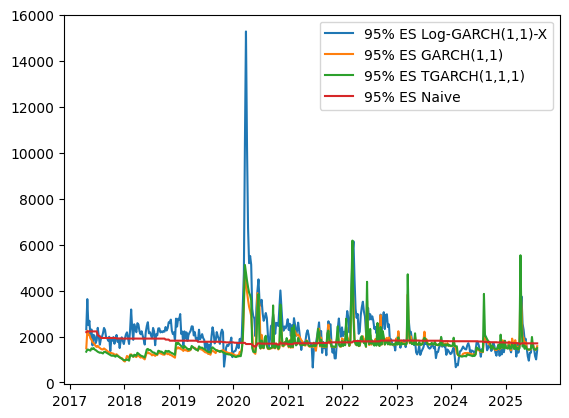

In [ ]:
# ES_LogGARCHX = np.mean(std_loss_LogGARCHX[std_loss_LogGARCHX * vol> VaR_LogGARCHX]) * vol / 0.05
# ES_GARCH = np.mean(std_loss_GARCH[std_loss_GARCH * res_garch.conditional_volatility > VaR_GARCH]) * res_garch.conditional_volatility / 0.05
# ES_naive = np.full(len(vol), np.mean(-combined['Log Return'][-combined['Log Return'] > VaR_naive])) / 0.05
plt.plot(combined.index[T:H], ES_LogGARCHX)
plt.plot(combined.index[T:H], ES_GARCH)
plt.plot(combined.index[T:H], ES_TGARCH)
plt.plot(combined.index[T:H], ES_naive)
plt.legend(['95% ES Log-GARCH(1,1)-X', '95% ES GARCH(1,1)','95% ES TGARCH(1,1,1)' , '95% ES Naive'])
plt.show()

In [ ]:
def Scroing_func(r1,r2,Y, alpha):
  S = np.where(Y > r1, 1, 0) * (Y - r1) / (2 * np.sqrt(r2)) + (1 - alpha) * (r1+r2) / (2 * np.sqrt(r2))
  return S

In [ ]:
av_Score_LogGARCHX = np.mean(Scroing_func(VaR_LogGARCHX, ES_LogGARCHX, -combined['Log Return'][T:H], 0.05))
av_Score_GARCH = np.mean(Scroing_func(VaR_GARCH, ES_GARCH, -combined['Log Return'][T:H], 0.05))
av_Score_TGARCH = np.mean(Scroing_func(VaR_TGARCH, ES_TGARCH, -combined['Log Return'][T:H], 0.05))
av_Score_naive = np.mean(Scroing_func(VaR_naive, ES_naive, -combined['Log Return'][T:H], 0.05))
print(f'Average Score Log-GARCH(1,1)-X: {av_Score_LogGARCHX}')
print(f'Average Score GARCH(1,1): {av_Score_GARCH}')
print(f'Average Score TGARCH(1,1,1): {av_Score_TGARCH}')
print(f'Average Score Naive: {av_Score_naive}')

Average Score Log-GARCH(1,1)-X: 22.256615994770698
Average Score GARCH(1,1): 19.7419121240616
Average Score TGARCH(1,1,1): 19.740783569219413
Average Score Naive: 20.84289605012584


In [ ]:
d_t = Scroing_func(VaR_TGARCH, ES_TGARCH, -combined['Log Return'][T:H], 0.05) - Scroing_func(VaR_naive, ES_naive, -combined['Log Return'][T:H], 0.05)
def sample_autocov(u_t, h):
 return 1 / len(u_t) * np.sum(u_t[h:] * u_t[:len(u_t) - h])

def QS_kernel(x):
  if x == 0:
    return 1
  else:
    QS1 = 25/(12 * (np.pi * x)**2)
    QS2 = np.sin(6 * np.pi * x / 5) / (6 * np.pi * x / 5)
    QS3 = np.cos(6 * np.pi * x / 5)
  return QS1 * (QS2 - QS3)


def hac_est_Andrews(d_t, b):
  u_t = d_t - np.mean(d_t)
  gamma_vector = np.zeros((len(u_t)-1,1))
  w = [QS_kernel((l+1)/b) for l in range(len(u_t)-1)]
  for l in range(len(u_t)-1):
    gamma_vector[l] = sample_autocov(u_t, l + 1)
  gamma_0 = sample_autocov(u_t, 0)
  return np.sqrt(gamma_0 + 2 * np.dot(gamma_vector.T, w))

def compute_b(s_t):
  y = np.asarray(s_t, float)[1:]
  x = np.asarray(s_t, float)[:-1]
  rho_hat = sm.OLS(y, sm.add_constant(x)).fit().params[1]
  alpha2 = 4 * rho_hat **2 / (1 - rho_hat) ** 4
  return 1.3221 * (len(s_t) * alpha2) ** 0.2

b = compute_b(d_t)



stat = -np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))

print(f'Statistic: {stat}')



Statistic: [1.69824909]


In [ ]:
data

,Price
Date,
2025-09-26,234.99
2025-09-25,231.81
2025-09-24,232.63
2025-09-23,231.89
2025-09-22,230.85
...,...
2009-01-06,157.90
2009-01-05,154.43
2009-01-02,153.37


In [ ]:
combined.to_csv('combined.csv')

Trying to do GARCH-X instead of log-GARCH-X

**Switch to R (no GARCH-X package in Python)**

In [ ]:
install.packages("rugarch")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘truncnorm’, ‘future.apply’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘xts’, ‘zoo’, ‘chron’, ‘SkewHyperbolic’, ‘fracdiff’, ‘nloptr’, ‘RcppArmadillo’




In [ ]:

library(rugarch)

df <- read.csv("combined.csv", check.names = TRUE)
df$Date <- as.Date(df$Date)

xvars <- c("VSTOXX", "VIX")

X <- as.matrix(df[ , xvars, drop = FALSE])
Xlag <- rbind(NA, X[-nrow(X), , drop = FALSE])

y    <- df$Log.Return[-1]
Vreg <- Xlag[-1, , drop = FALSE]
dates <- df$Date[-1]

H <- length(y)
T <- floor(H/2)


hhat <- rep(NA_real_, H)   # conditional variance estimates/forecasts


spec0 <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1),
                        external.regressors = as.matrix(Vreg[1:T, ])),
  mean.model     = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "norm"
)

fit0 <- ugarchfit(spec = spec0, data = y[1:T], solver = "hybrid")
hhat[1:T] <- sigma(fit0)^2

for (t in T:(H-1)) {
  idx <- (t - T + 1):t
  spec_roll <- ugarchspec(
    variance.model = list(model = "sGARCH", garchOrder = c(1,1),
                          external.regressors = as.matrix(Vreg[idx, ])),
    mean.model     = list(armaOrder = c(0,0), include.mean = FALSE),
    distribution.model = "std"
  )
  fit_roll <- ugarchfit(spec_roll, data = y[idx], solver = "hybrid")
  fc <- ugarchforecast(fit_roll, n.ahead = 1,
                       external.forecasts = list(vreg = matrix(Vreg[t+1, ], nrow = 1)))
  hhat[t+1] <- sigma(fc)^2  # 1-step ahead variance forecast
}


out <- data.frame(Date = dates, Condvol = sqrt(hhat))
write.csv(out, "vol_GARCHX.csv", row.names = FALSE)

tail(out)


,Date,Condvol
,<date>,<dbl>
860,2025-06-27,22.60345
861,2025-07-04,19.17902
862,2025-07-11,12.95286
863,2025-07-18,11.36640
864,2025-07-25,38.96050
865,2025-08-01,19.55936


**Switch to Python**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [ ]:
vol_GARCHX = pd.read_csv('vol_GARCHX.csv')['Condvol']
first = vol_GARCHX.iloc[0]
vol_GARCHX = pd.concat([pd.Series([first], index=[-1]), vol_GARCHX]).reset_index(drop=True).to_numpy()

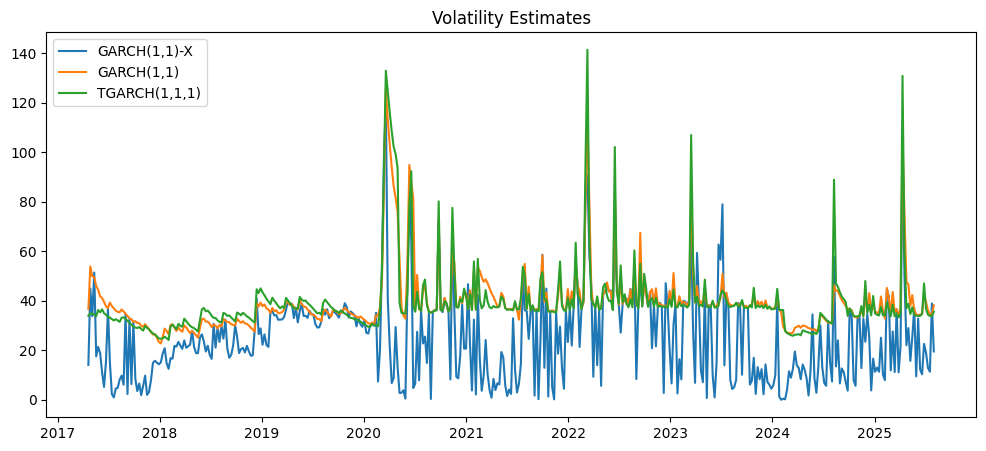

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(combined.index[T:H], vol_GARCHX[T:H], label='GARCH(1,1)-X')
plt.plot(combined.index[T:H], vol_GARCH[T:H], label='GARCH(1,1)')
plt.plot(combined.index[T:H], vol_TGARCH[T:H], label='TGARCH(1,1,1)')
plt.legend(['GARCH(1,1)-X', 'GARCH(1,1)', 'TGARCH(1,1,1)'])
plt.title('Volatility Estimates')
plt.show()

In [ ]:
std_loss_GARCHX = np.zeros(H)
std_loss_GARCH = np.zeros(H)
std_loss_TGARCH = np.zeros(H)
std_loss_GARCHX[0:T] = - combined['Log Return'][0:T] / vol_GARCHX[0:T]
std_loss_GARCH[0:T] = - combined['Log Return'][0:T] / vol_GARCH[0:T]
std_loss_TGARCH[0:T] = - combined['Log Return'][0:T] / vol_TGARCH[0:T]

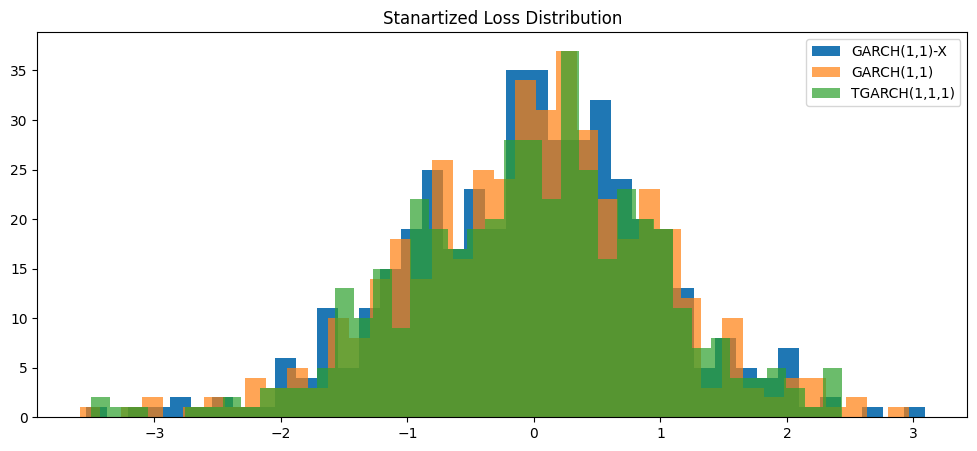

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(std_loss_GARCHX[0:T], bins=40)
plt.hist(std_loss_GARCH[0:T], bins=40, alpha=0.7)
plt.hist(std_loss_TGARCH[0:T], bins=40, alpha=0.7)
plt.legend(['GARCH(1,1)-X', 'GARCH(1,1)', 'TGARCH(1,1,1)'])
plt.title('Stanartized Loss Distribution')
plt.show()

In [ ]:
VaR_GARCHX = np.zeros(H-T)
VaR_GARCH = np.zeros(H-T)
VaR_TGARCH = np.zeros(H-T)
VaR_naive = np.zeros(H-T)
ES_GARCHX = np.zeros(H-T)
ES_GARCH = np.zeros(H-T)
ES_TGARCH = np.zeros(H-T)
ES_naive = np.zeros(H-T)
for t in range(T,H):
  std_loss_GARCHX[t] = - combined['Log Return'][t] / vol_GARCHX[t]
  std_loss_GARCH[t] = - combined['Log Return'][t] / vol_GARCH[t]
  std_loss_TGARCH[t] = - combined['Log Return'][t] / vol_TGARCH[t]
  VaR_GARCHX[t-T] = np.quantile(std_loss_GARCHX[t-T:t], 0.95) * vol_GARCHX[t]
  VaR_GARCH[t-T] = np.quantile(std_loss_GARCH[t-T:t], 0.95) * vol_GARCH[t]
  VaR_TGARCH[t-T] = np.quantile(std_loss_TGARCH[t-T:t], 0.95) * vol_TGARCH[t]
  VaR_naive[t-T] = np.quantile(-combined['Log Return'][t-T:t], 0.95)
  ES_GARCHX[t-T] = np.mean(std_loss_GARCHX[t-T:t][std_loss_GARCHX[t-T:t] * vol_GARCHX[t] > VaR_GARCHX[t-T]]) * vol_GARCHX[t] / 0.05
  ES_GARCH[t-T] = np.mean(std_loss_GARCH[t-T:t][std_loss_GARCH[t-T:t] * vol_GARCH[t] > VaR_GARCH[t-T]]) * vol_GARCH[t] / 0.05
  ES_TGARCH[t-T] = np.mean(std_loss_TGARCH[t-T:t][std_loss_TGARCH[t-T:t] * vol_TGARCH[t] > VaR_TGARCH[t-T]]) * vol_TGARCH[t] / 0.05
  ES_naive[t-T] = np.mean(-combined['Log Return'][t-T:t][-combined['Log Return'][t-T:t] > VaR_naive[t-T]]) / 0.05

/tmp/ipython-input-1191344990.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_loss_GARCHX[t] = - combined['Log Return'][t] / vol_GARCHX[t]
/tmp/ipython-input-1191344990.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_loss_GARCH[t] = - combined['Log Return'][t] / vol_GARCH[t]
/tmp/ipython-input-1191344990.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_loss_TGARCH[t] = - combined['Log Return'][t] / vol_TGAR

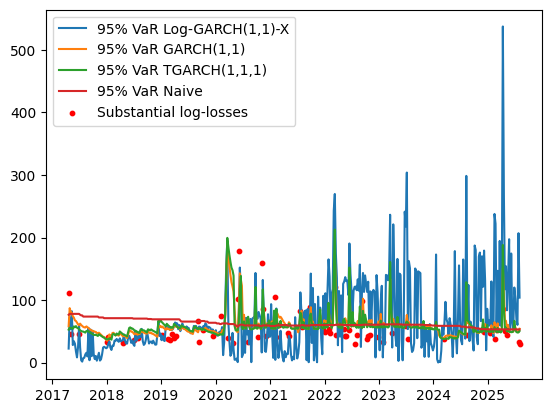

In [ ]:
plt.plot(combined.index[T:H], VaR_GARCHX)
plt.plot(combined.index[T:H], VaR_GARCH)
plt.plot(combined.index[T:H], VaR_TGARCH)
plt.plot(combined.index[T:H], VaR_naive)
plt.scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], color='r',  s=10)
plt.legend(['95% VaR Log-GARCH(1,1)-X', '95% VaR GARCH(1,1)', '95% VaR TGARCH(1,1,1)','95% VaR Naive', 'Substantial log-losses'])
plt.show()

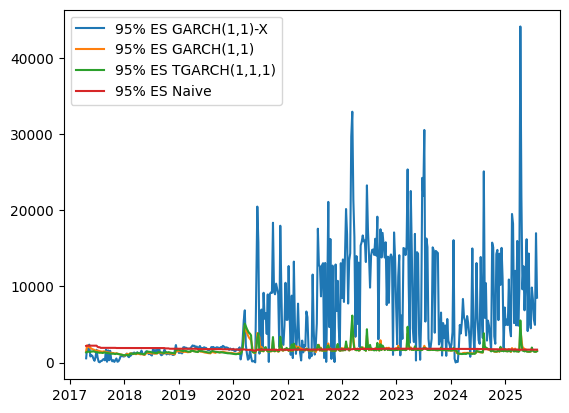

In [ ]:
plt.plot(combined.index[T:H], ES_GARCHX)
plt.plot(combined.index[T:H], ES_GARCH)
plt.plot(combined.index[T:H], ES_TGARCH)
plt.plot(combined.index[T:H], ES_naive)
plt.legend(['95% ES GARCH(1,1)-X', '95% ES GARCH(1,1)','95% ES TGARCH(1,1,1)' , '95% ES Naive'])
plt.show()

In [ ]:
def Scroing_func(r1,r2,Y, alpha):
  S = np.where(Y > r1, 1, 0) * (Y - r1) / (2 * np.sqrt(r2)) + (1 - alpha) * (r1+r2) / (2 * np.sqrt(r2))
  return S

In [ ]:
av_Score_LogGARCHX = np.mean(Scroing_func(VaR_GARCHX, ES_GARCHX, -combined['Log Return'][T:H], 0.05))
av_Score_GARCH = np.mean(Scroing_func(VaR_GARCH, ES_GARCH, -combined['Log Return'][T:H], 0.05))
av_Score_TGARCH = np.mean(Scroing_func(VaR_TGARCH, ES_TGARCH, -combined['Log Return'][T:H], 0.05))
av_Score_naive = np.mean(Scroing_func(VaR_naive, ES_naive, -combined['Log Return'][T:H], 0.05))
print(f'Average Score Log-GARCH(1,1)-X: {av_Score_LogGARCHX}')
print(f'Average Score GARCH(1,1): {av_Score_GARCH}')
print(f'Average Score TGARCH(1,1,1): {av_Score_TGARCH}')
print(f'Average Score Naive: {av_Score_naive}')

Average Score Log-GARCH(1,1)-X: 32.822421147678
Average Score GARCH(1,1): 19.7419121240616
Average Score TGARCH(1,1,1): 19.740783569219413
Average Score Naive: 20.84289605012584


In [ ]:
d_t = Scroing_func(VaR_TGARCH, ES_TGARCH, -combined['Log Return'][T:H], 0.05) - Scroing_func(VaR_GARCHX, ES_GARCHX, -combined['Log Return'][T:H], 0.05)
def sample_autocov(u_t, h):
 return 1 / len(u_t) * np.sum(u_t[h:] * u_t[:len(u_t) - h])

def QS_kernel(x):
  if x == 0:
    return 1
  else:
    QS1 = 25/(12 * (np.pi * x)**2)
    QS2 = np.sin(6 * np.pi * x / 5) / (6 * np.pi * x / 5)
    QS3 = np.cos(6 * np.pi * x / 5)
  return QS1 * (QS2 - QS3)


def hac_est_Andrews(d_t, b):
  u_t = d_t - np.mean(d_t)
  gamma_vector = np.zeros((len(u_t)-1,1))
  w = [QS_kernel((l+1)/b) for l in range(len(u_t)-1)]
  for l in range(len(u_t)-1):
    gamma_vector[l] = sample_autocov(u_t, l + 1)
  gamma_0 = sample_autocov(u_t, 0)
  return np.sqrt(gamma_0 + 2 * np.dot(gamma_vector.T, w))

def compute_b(s_t):
  y = np.asarray(s_t, float)[1:]
  x = np.asarray(s_t, float)[:-1]
  rho_hat = sm.OLS(y, sm.add_constant(x)).fit().params[1]
  alpha2 = 4 * rho_hat **2 / (1 - rho_hat) ** 4
  return 1.3221 * (len(s_t) * alpha2) ** 0.2

b = compute_b(d_t)



stat = -np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))

print(f'Statistic: {stat}')

Statistic: [4.58022102]
